# Statistical Rethinking  Chapter 4: Linear Models  Examples and Exercises

In [1]:
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import describe
from scipy.optimize import minimize
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
import seaborn as sns
import pymc3 as pm
import arviz as az
import numdifftools as nd

# 4.3: A Gaussian model of height

In [2]:
Howell1 = pd.read_csv('Data/Howell1.csv', sep = ';')
type(Howell1)
Howell1.columns
Howell1.shape

(544, 4)

In [3]:
type(Howell1['height'])
type(Howell1[['height']])
d2 = Howell1[['height']][Howell1['age'] >= 18]
type(d2)
d2.describe()

,height
count,352.000000
mean,154.597093
std,7.742332
min,136.525000
25%,148.590000
50%,154.305000
75%,160.655000
max,179.070000


plot observed data

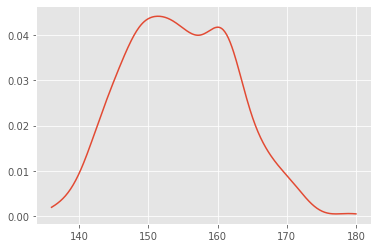

In [4]:
x_plot = np.linspace(136, 180, len(d2))[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=2)
kde.fit(d2)
y = np.exp(kde.score_samples(x_plot))
plt.plot(x_plot, y)
plt.show()

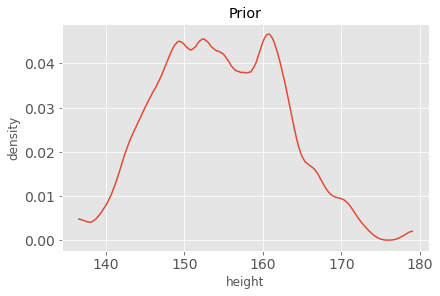

In [5]:
pm.kdeplot(d2)
plt.xlabel('height')
plt.ylabel('density')
plt.title('Prior')
plt.show()

code chunk 4.13 (set up prior)

/home/method/.pyenv/versions/pymc3/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


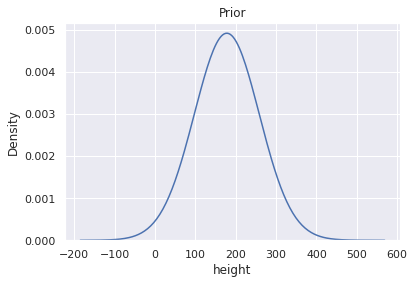

In [6]:
sample_mu = norm.rvs(loc=178, scale=20, size=1000)
sample_sigma = uniform.rvs(0, 50, 1000)
prior_h = norm.rvs(sample_mu, sample_sigma, 1000)
sns.set_theme(style='darkgrid')
ax = sns.kdeplot(prior_h, bw=2)
ax.set(xlabel='height', title='Prior')
plt.show()

code chunk 4.14 (grid estimation)

In [7]:
mu_grid = np.linspace(140, 160, 200)
sigma_grid = np.linspace(4, 9, 200)
post_list = [sum(norm.logpdf(d2,m,s)) for m in mu_grid for s in sigma_grid]
post_ll = np.concatenate(post_list, axis=0)

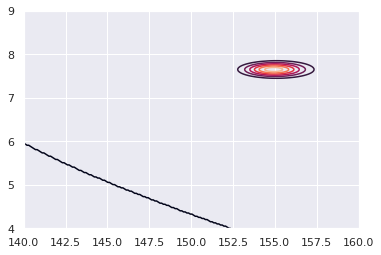

In [8]:
mu_grid_rep = np.repeat(mu_grid, 200)
sigma_grid_rep = np.tile(sigma_grid, 200)
len(post_ll) == len(mu_grid_rep) and len(post_ll) == len(sigma_grid_rep)
post_log_prob = post_ll + norm.logpdf(mu_grid_rep, 178, 20) + uniform.logpdf(sigma_grid_rep, 0, 50)
post_prob = np.exp(post_log_prob - max(post_log_prob))
X, Y = np.meshgrid(mu_grid, sigma_grid)
Z = post_prob.reshape(200,200)
plt.contour(X,Y,Z)
plt.show()

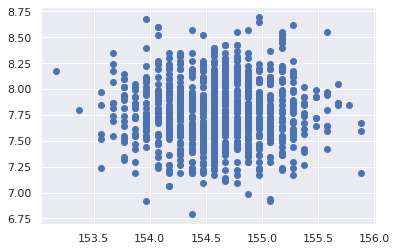

In [9]:
post_prob_std = post_prob/sum(post_prob)
sample_rows = np.random.choice(range(len(post_prob)), size=1000, replace=True, p=post_prob_std)
sample_mu = mu_grid_rep[sample_rows]
sample_sigma = sigma_grid_rep[sample_rows]
plt.scatter(sample_mu, sample_sigma)
plt.show()

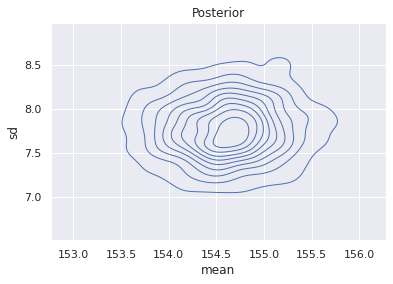

In [10]:
sns.kdeplot(x=sample_mu, y=sample_sigma, color="b", linewidths=1)
plt.xlabel('mean')
plt.ylabel('sd')
plt.title('Posterior')
plt.show()

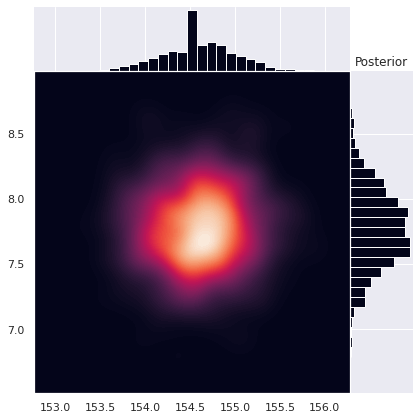

In [11]:
g = sns.JointGrid(x=sample_mu, y=sample_sigma, space=0)
g.plot_joint(sns.kdeplot,
             fill=True, #clip=((2200, 6800), (10, 25)),
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)
plt.title('Posterior')
plt.show()

repeat with pymc3 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, sigma]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 5 seconds.


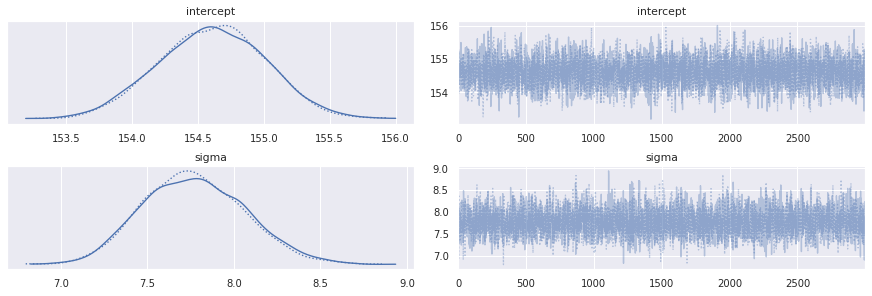

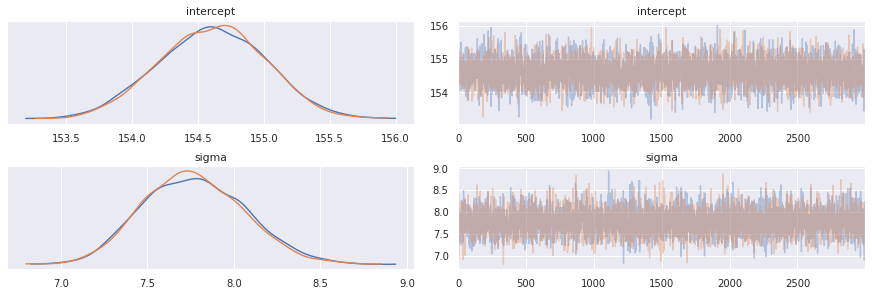

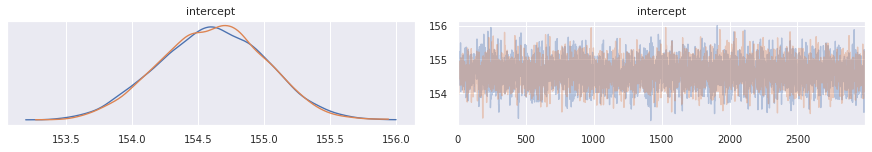

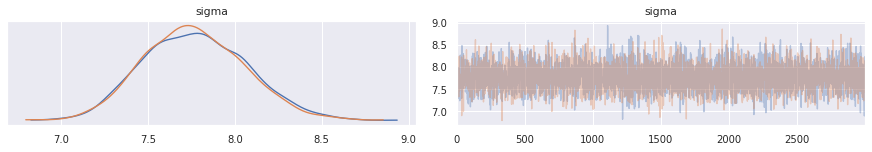

In [12]:
with pm.Model() as model:
    # define priors
    sigma = pm.Uniform('sigma', 0, 50) # sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('intercept', 178, sigma=20)
    # define likelihood
    likelihood = pm.Normal('d2', mu=intercept, sigma=sigma, observed=d2)
    # inference
    trace = pm.sample(3000, cores=2, return_inferencedata=True)
az.summary(trace)
az.summary(trace.posterior['intercept'])
pm.traceplot(trace)
plt.show()
az.plot_trace(trace)
az.plot_trace(trace, var_names=['intercept'])
plt.show()
az.plot_trace(trace, var_names=['sigma'])
plt.show()

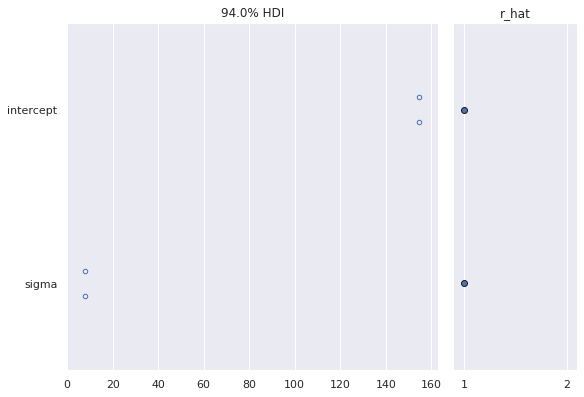

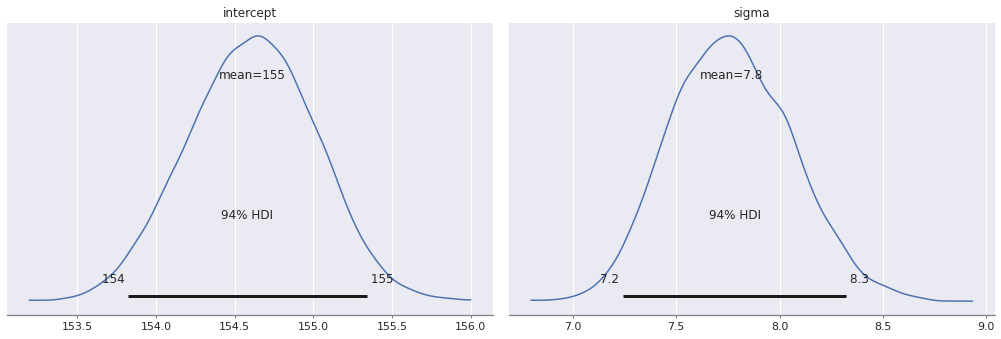

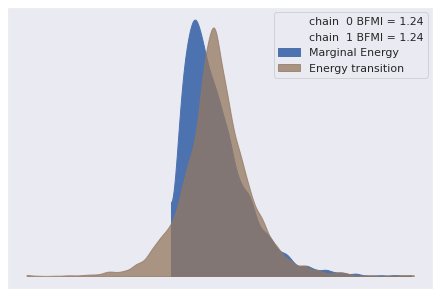

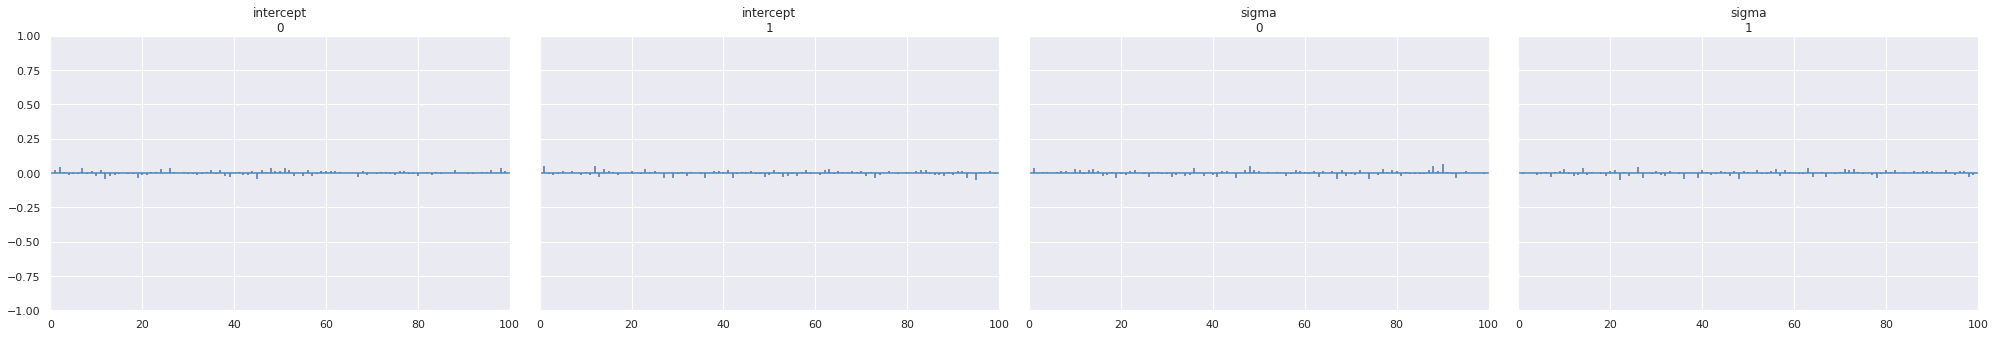

In [13]:
az.plot_forest(trace, r_hat=True)
plt.show()
az.plot_posterior(trace)
plt.show()
az.plot_energy(trace)
plt.show()
az.plot_autocorr(trace, var_names=["intercept", "sigma"]);
plt.show()

map() by hand

In [14]:
def negPost (x, *args):
    y = args[0]
    p = -1 * sum(norm.logpdf(y,x[0],x[1]))[0] + norm.logpdf(x[0],178,20) + uniform.logpdf(x[1], 0, 50)
    return p
negPost((178,3), d2)
secondDerivPost = nd.Derivative(negPost, n=2, full_output=True)

In [15]:
modePost1 = minimize(negPost, x0=(178,10), args=d2,
                     method='nelder-mead', options={'disp':True})
modePost1.success
modePost1.x

Optimization terminated successfully.
         Current function value: 1210.893487
         Iterations: 50
         Function evaluations: 99


array([154.5871953 ,   7.73131604])

In [16]:
grad = nd.Gradient(negPost)
grad(list(modePost1.x), d2)
hess = nd.Hessian(negPost)
np.sqrt(1/np.diag(hess(list(modePost1.x), d2)))

array([0.41216803, 0.29138398])